In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import scipy
from torch.autograd import Variable

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
seed = 10
np.random.seed(seed)
torch.manual_seed(seed)


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [5]:
from pathlib import Path
from typing import Any, Tuple, Callable, Optional
import random
import PIL.Image

class NewFlowers(torchvision.datasets.flowers102.Flowers102):
  def __init__(
        self,
        root: str,
        split: str = "train",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:
    super().__init__(root, split, transform, target_transform, download)
    self._labels = np.array(self._labels, dtype="int")
    
  def __getitem__(self, item):
    
    #obtain indexes of all the labels
    index = np.array(list(range(0, len(self._labels))), dtype="int")
    
    #obtain anchor image 
    anchor_img = self._image_files[item]
    anchor_img = PIL.Image.open(anchor_img).convert("RGB")
    
    #obtain anchor label
    anchor_label = self._labels[item]

    #generate positive index list where it is not the same class as the anchor
    positive_list = index[index!=item][self._labels[index!=item]==anchor_label]
    
    #randomly obtain 1 positive item and its respective image
    positive_item = random.choice(positive_list)
    positive_img = self._image_files[positive_item]
    positive_img = PIL.Image.open(positive_img).convert("RGB")

    #generate negative index list where it is not the same class as the anchor
    negative_list = index[index!=item][self._labels[index!=item]!=anchor_label]
    
    #randomly obtain 1 negative item and its respective image
    negative_item = random.choice(negative_list)
    negative_img = self._image_files[negative_item]
    negative_img = PIL.Image.open(negative_img).convert("RGB")

    #apply transformation on images
    anchor_img = self.transform(anchor_img)
    positive_img = self.transform(positive_img)
    negative_img = self.transform(negative_img)

    return (anchor_img, positive_img, negative_img), anchor_label


In [6]:
triplet_train = NewFlowers("./data/train", split="train", download=True, transform=data_transforms["train"])
triplet_val = NewFlowers("./data/train", split="val", download=True, transform=data_transforms["val"])
triplet_test = NewFlowers("./data/train", split="test", download=True, transform=data_transforms["test"])

In [7]:
triplet_train_dataloader = torch.utils.data.DataLoader(triplet_train, batch_size=16, shuffle=True)
triplet_val_dataloader = torch.utils.data.DataLoader(triplet_val, batch_size=16, shuffle=True)
triplet_test_dataloader = torch.utils.data.DataLoader(triplet_test, batch_size=16, shuffle=True)

In [8]:
image_datasets = {
    'train': triplet_train,
    'val': triplet_val,
    'test': triplet_test
}


dataloaders = {
    "train": triplet_train_dataloader,
    "val": triplet_val_dataloader,
    "test": triplet_test_dataloader,
}

dataset_sizes = {
        x: len(dataloaders[x].dataset)
        for x in list(image_datasets.keys())
    }

In [9]:
dataset_sizes

{'train': 1020, 'val': 1020, 'test': 6149}

In [10]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [11]:
anchor, positive, negative = 0,0,0
for i, (inputs, labels) in enumerate(triplet_train_dataloader):
#     print(labels)
    anchor, positive, negative = inputs
    break

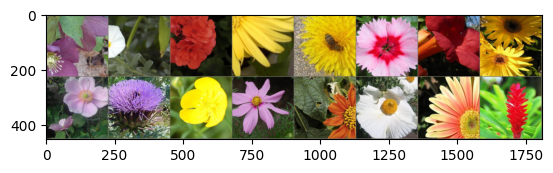

In [12]:
anchor_out = torchvision.utils.make_grid(anchor)
imshow(anchor_out)

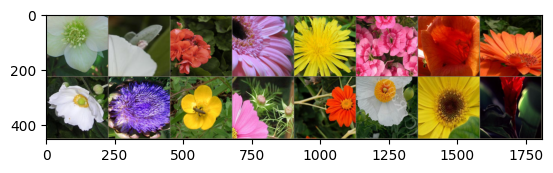

In [13]:
positive_out = torchvision.utils.make_grid(positive)
imshow(positive_out)

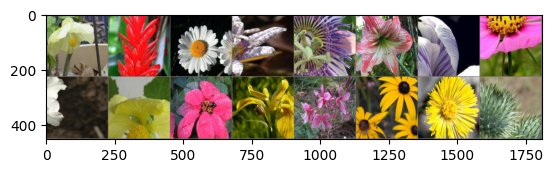

In [14]:
negative_out = torchvision.utils.make_grid(negative)
imshow(negative_out)

In [15]:
import torch
import time

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()
    
    # Initialize lists to store training and validation loss/accuracy for each epoch
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    # Dynamically set device: Use GPU if available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)

    # Define Cross Entropy Loss separately
    crossEntropyLoss = torch.nn.CrossEntropyLoss()

    best_acc = 0.0  # Track the best validation accuracy

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for step, (inputs, anchor_label) in enumerate(dataloaders[phase]):
                # Unpack the triplet images (anchor, positive, negative)
                anchor_img, positive_img, negative_img = inputs

                # Move the images to the selected device (CPU/GPU)
                anchor_img = anchor_img.to(device)
                positive_img = positive_img.to(device)
                negative_img = negative_img.to(device)
                
                # Convert anchor_label to LongTensor and move to device
                anchor_label = anchor_label.to(device).long()

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    # Get embeddings for the triplets
                    anchor_out = model(anchor_img)
                    positive_out = model(positive_img)
                    negative_out = model(negative_img)
                    
                    # Predictions for accuracy calculation
                    _, preds = torch.max(anchor_out, 1)

                    # Calculate Triplet Loss
                    triplet_loss = criterion(anchor_out, positive_out, negative_out)

                    # Calculate Cross Entropy Loss for classification
                    celoss = crossEntropyLoss(anchor_out, anchor_label)

                    # Combine both losses
                    loss = triplet_loss + celoss

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Accumulate loss and correct predictions
                running_loss += loss.item() * len(anchor_label)
                running_corrects += torch.sum(preds == anchor_label).item()

            if phase == 'train':
                scheduler.step()

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store metrics for plotting
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            # Track best accuracy (for monitoring purposes)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

        print()  # Newline for readability between epochs

    # Print total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation accuracy: {best_acc:.4f}\n')

    # Return the model and metrics
    return model, train_loss, train_acc, val_loss, val_acc


In [16]:
def plot_graph(no_epoch, train, val, title):
    plt.figure()
    plt.plot(range(no_epoch), train, label='train')
    plt.plot(range(no_epoch), val, label='val')
    if "Accuracy" in title:
        plt.ylabel("Accuracy")
    elif "Loss" in title:
        plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [17]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

# Modify the WeightsEnum get_state_dict if necessary (might not be needed in all versions of torchvision)
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash", None)  # Pop check_hash if it's present
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

# Load the pre-trained model
model_conv = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in model_conv.parameters():
    param.requires_grad = False

# Replace the classifier layer for a new task with 102 classes
num_ftrs = model_conv.classifier[1].in_features
model_conv.classifier[1] = nn.Linear(num_ftrs, 102)


In [18]:
print(model_conv)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [19]:
from torch import optim
from torch.optim import lr_scheduler

num_epochs = 40

model_conv = model_conv.to(device)

# Observe that only parameters of the final layer are being optimized
optimizer_conv = optim.SGD(model_conv.classifier[1].parameters(), lr=0.001, momentum=0.9)

# Set up the criterion
criterion = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)

# Decay LR by a factor of 0.1 every 7 epochs (or adjust based on training length)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [20]:
model_conv, train_loss, train_acc, val_loss, val_acc = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, dataloaders, dataset_sizes, num_epochs=num_epochs)

Using device: cuda
Epoch 1/40
----------
train Loss: 5.3384 Acc: 0.0137
val Loss: 4.9557 Acc: 0.0324

Epoch 2/40
----------
train Loss: 4.9839 Acc: 0.0441
val Loss: 4.6491 Acc: 0.1333

Epoch 3/40
----------
train Loss: 4.7121 Acc: 0.1412
val Loss: 4.4284 Acc: 0.2735

Epoch 4/40
----------
train Loss: 4.4605 Acc: 0.2598
val Loss: 4.2151 Acc: 0.3922

Epoch 5/40
----------
train Loss: 4.3401 Acc: 0.3176
val Loss: 4.0423 Acc: 0.4647

Epoch 6/40
----------
train Loss: 4.1301 Acc: 0.4225
val Loss: 3.8722 Acc: 0.5235

Epoch 7/40
----------
train Loss: 4.0041 Acc: 0.5020
val Loss: 3.7245 Acc: 0.5882

Epoch 8/40
----------
train Loss: 3.8824 Acc: 0.5441
val Loss: 3.7210 Acc: 0.5892

Epoch 9/40
----------
train Loss: 3.8876 Acc: 0.5373
val Loss: 3.7161 Acc: 0.5873

Epoch 10/40
----------
train Loss: 3.8950 Acc: 0.5441
val Loss: 3.7214 Acc: 0.6029

Epoch 11/40
----------
train Loss: 3.8352 Acc: 0.5529
val Loss: 3.6610 Acc: 0.6059

Epoch 12/40
----------
train Loss: 3.8555 Acc: 0.5765
val Loss: 3.